# Visualize model predictions

Ensure that samples entered are in the test set or validation set

In [3]:
import os
import sys
from pytorch_lightning import Trainer
import albumentations as A
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl

sys.path.append('models/')
from UNet_mateuszbuda import UNet_m
from loss import DiceLoss
from loss import DiceLoss2

sys.path.append('data/')
from CTDataSet import CTDicomSlices, DatasetManager
from CustomTransforms import Window
from CustomTransforms import Imagify

sys.path.append('tests')
from test_CTDataSet import plot_slices_and_mask

### Plotting function

In [4]:
def plot_img_and_mask(img, mask, text = ""):
    mask = mask * 255

    fig = plt.figure(figsize=(15,15))
    cols, rows = 2, 1
    
    fig.add_subplot(rows, cols, 1)
    plt.imshow(img.numpy())
    
    fig.add_subplot(rows, cols, 2)
    plt.imshow(mask.numpy())
    
    plt.show()

### Some constants

In [5]:
WL = 50
WW = 200

img_size = 256

def to_float(x, **kwargs):
    return x.astype('float32')

### Create the relevant transforms

In [6]:
_image_transforms = [
    Window(WL, WW),
    Imagify(WL, WW),
    #preprocess_fn,
    to_float,
]

_img_mask_tsfm = A.Compose([A.Resize(img_size, img_size)],
            additional_targets={"image1": 'image', "mask1": 'mask'})

image_transforms = transforms.Compose(_image_transforms)
img_mask_tsfm = A.Compose(_img_mask_tsfm)

### Build the relevant datasets

In [11]:
main_dir = "../model_runs"
model_name = "2020-07-23-23:46:54"
model_dir = "{}/{}".format(main_dir, model_name)
checkpoint_f = 'epoch=1.ckpt'

dataset = "../organized_dataset"

dsm = DatasetManager.load_train_val_test(dataset, "{}/train.txt".format(model_dir), "{}/val.txt".format(model_dir), "{}/test.txt".format(model_dir))

train_dicoms, val_dicoms, test_dicoms = dsm.get_dicoms() # DICOM glob is preset in the class file

test_ds = CTDicomSlices(test_dicoms, preprocessing = image_transforms, img_and_mask_transform = img_mask_tsfm)

test_dl = DataLoader(test_ds, batch_size=1, num_workers = 0, shuffle=True)

In [12]:
chkpt = "{}/lightning_logs/version_0/checkpoints/{}".format(model_dir, checkpoint_f)

model = UNet_m.load_from_checkpoint(chkpt)

In [9]:
slices.shape

NameError: name 'slices' is not defined

Input file is: ('../organized_dataset/HNSCC-01-0310/dicoms/163.dcm',)
Dice score 2 is: 50.864%


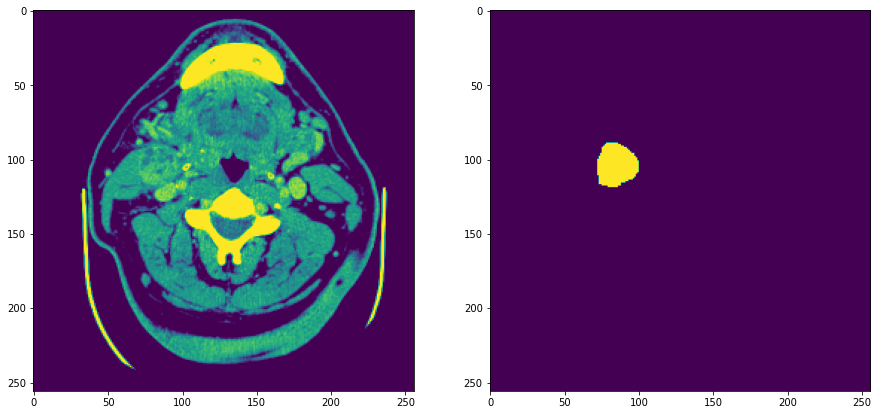

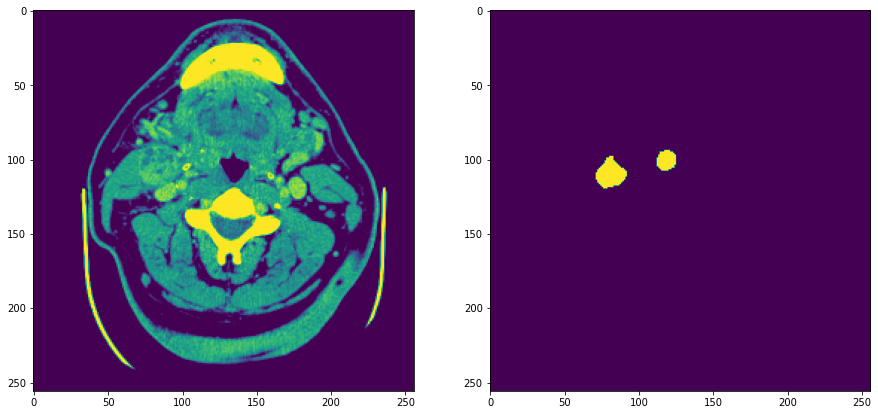

tensor(0., grad_fn=<RoundBackward>)


In [41]:
loss = DiceLoss()
loss2 = DiceLoss2()

max = 1
for i, (slices, mask, img_path, slice_n) in enumerate(test_dl):
    if i >= max:
        break
    
    y_pred = model(slices)

    mask = mask.type(torch.float32)
    
    print("Input file is: {}".format(img_path))
    print("Dice score 2 is: {:.3f}%".format((1 - loss2(torch.round(y_pred[:,0,:,:]), mask)) * 100))
    
    #print(y_pred.shape)
    #print(mask[0].shape)
    plot_img_and_mask(slices[0,:,:,1], mask[0], slice_n)
    plot_img_and_mask(slices[0,:,:,1], torch.round(y_pred[0,0,:,:].detach()), slice_n)
    
    print(torch.round(y_pred[0, 0, 10, 10]))

In [ ]:
slices, mask, img_path, slice_n = next(iter(test_dl))

mask = mask.type(torch.float32)
y_pred = model(slices)

print(mask.shape)
print(torch.round(y_pred[:,0,:,:]).shape)

print(pl.metrics.functional.dice_score(torch.round(y_pred[:,0,:,:]), mask))
print(loss(torch.round(y_pred[:,0,:,:]), mask))